In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:

from tensorflow.keras.applications import ResNet50

pre_model = ResNet50(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

# Make all the layers in the pre-model non-trainable
for layer in pre_model.layers:
    layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
pre_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:

last_layer = pre_model.get_layer('conv5_block3_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 2048)


In [ ]:
loss = 'mean_squared_error'
metrics = ['mse','mae']
batch_size=64
epochs = 10

In [ ]:
from tensorflow.keras.optimizers import Adam


x = layers.MaxPool2D(strides=(2,2), padding='valid')(last_output)
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)                  
# Add a final linear layer for classification
x = layers.Dense  (1, activation='linear')(x)           

model = Model( pre_model.input, x) 

model.compile(optimizer = tf.keras.optimizers.Adam(0.01), 
              loss = 'mean_squared_error',
              metrics = metrics) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
raw_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SDSS.csv")
train_df = raw_dataset.copy()
train_df.head()

,img_path,z
0,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.037450
1,/content/drive/MyDrive/Colab Notebooks/galaxy_...,-99.990000
2,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.029610
3,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.002882
4,/content/drive/MyDrive/Colab Notebooks/galaxy_...,0.038340


In [ ]:
import numpy as np
cnt=0
for row in train_df['z']:
    try:
        if row==-99.99 or row==-100  :
          train_df.loc[cnt, 'z']=np.nan
    except ValueError:
        pass
    cnt+=1

In [ ]:
train_df.isna().sum()

img_path       0
z           1357
dtype: int64

In [ ]:
# median = train_df['z'].median()
# train_df['z'].fillna(median, inplace=True)
train_df=train_df.dropna()

In [ ]:
train_df.isna().sum()

img_path    0
z           0
dtype: int64

In [ ]:
dataset=train_df.copy()

In [ ]:
train_df = dataset.sample(frac=0.8, random_state=0)
test_df = dataset.drop(train_df.index)

In [ ]:
datagen = ImageDataGenerator( 
            rescale=1./255.,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.35,
            fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col="img_path",
            y_col="z",
            subset="training",
            batch_size=32,
            seed=42,
            shuffle=True,
            class_mode="other",
            target_size=(224, 224))

valid_generator=datagen.flow_from_dataframe(
            dataframe=train_df,
            directory=None,
            x_col="img_path",
            y_col="z",
            subset="validation",
            batch_size=32,
            seed=42,
            class_mode="other",
            target_size=(224, 224))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col="img_path",
            y_col=None,
            batch_size=batch_size,
            seed=42,
            class_mode=None,
            target_size=(224, 224))           

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 1613 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 868 validated image filenames.
Found 620 validated image filenames.


In [ ]:
from keras.callbacks import EarlyStopping
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

# class myCallback(tf.keras.callbacks.Callback): 
#     def on_epoch_end(self, epoch, logs={}): 
#         if(logs.get('loss') < 0.001):   
#           print("\nReached %2.2f%% loss, so stopping training!!" %(0.001*100))   
#           self.model.stop_training = True

# callbacks = myCallback()

In [ ]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=50,
                    steps_per_epoch=10,
                    verbose=1,
                    callbacks=[earlystopper])

Epoch 1/50
10/10 [==============================] - 241s 25s/step - loss: 1577842.4347 - mse: 1577842.4347 - mae: 619.5948 - val_loss: 0.0055 - val_mse: 0.0055 - val_mae: 0.0543
Epoch 2/50
10/10 [==============================] - 195s 21s/step - loss: 70.0481 - mse: 70.0481 - mae: 2.5203 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0697
Epoch 3/50
10/10 [==============================] - 193s 20s/step - loss: 3.0506 - mse: 3.0506 - mae: 0.2575 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0756
Epoch 4/50
10/10 [==============================] - 192s 20s/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0746 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0781
Epoch 5/50
10/10 [==============================] - 191s 20s/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0797 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0790
Epoch 6/50
10/10 [==============================] - 191s 20s/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0781 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0794


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,865702.125000,865702.125000,352.964874,0.005525,0.005525,0.054302,0
1,50.396721,50.396721,1.832284,0.007439,0.007439,0.069725,1
2,16.736835,16.736835,1.095972,0.008299,0.008299,0.075647,2
3,0.005859,0.005859,0.075239,0.008675,0.008675,0.078092,3
4,0.006713,0.006713,0.078229,0.008822,0.008822,0.079026,4
5,0.006251,0.006251,0.077970,0.008877,0.008877,0.079373,5
6,0.022243,0.022243,0.083877,0.008897,0.008897,0.079498,6
7,0.022394,0.022394,0.084889,0.008902,0.008902,0.079531,7
8,0.022177,0.022177,0.083526,0.008901,0.008901,0.079522,8


In [ ]:

def plot_loss(hist):
  plt.plot(hist['loss'], label='loss')
  plt.plot(hist['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)


  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Err [z]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Err [$z^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.legend()



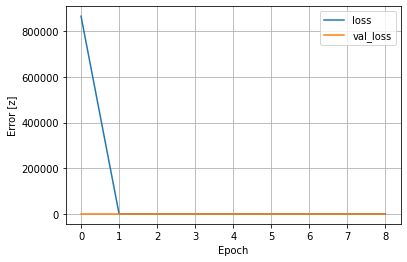

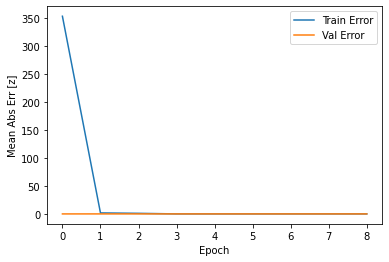

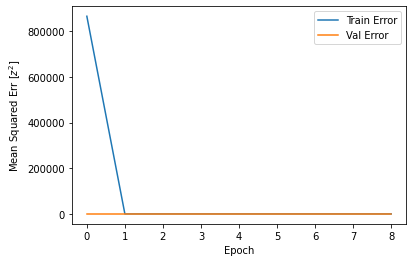

In [ ]:
plot_loss(hist)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/MainZmodel_resNet50")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/MainZmodel_resNet50/assets


In [ ]:
test_features = test_df.copy()
test_labels = test_features.pop('z')

In [ ]:
test_predictions = model.predict(test_generator).flatten()


In [ ]:
test_predictions = np.load('/content/drive/MyDrive/Colab Notebooks/resNet50predictions.npy')

In [ ]:
plt.scatter(test_generator, test_labels)
plt.plot(test_generator, test_predictions, c='red')

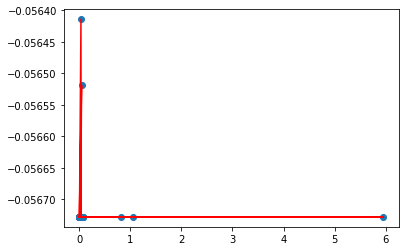

In [ ]:
plt.scatter(test_labels, test_predictions)
plt.plot(test_labels, test_predictions, c='red')

In [ ]:
result={}

In [ ]:
result['Predicted'] = test_predictions

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/MainresNet50predictions', test_predictions)

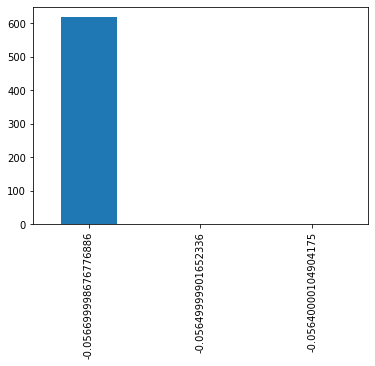

In [ ]:
fig1 = plt.gcf()
pd.value_counts(result['Predicted'].round(4)).sort_index().plot(kind="bar")

In [ ]:
spec=test_labels.to_numpy()
outlier=(spec-test_predictions)/(1+spec)
outlier

array([0.09077836, 0.09155769, 0.86433597, 0.11129453, 0.06769196,
       0.073434  , 0.07334297, 0.07256854, 0.09086599, 0.09034872,
       0.10389027, 0.07289669, 0.07383429, 0.07362509, 0.07112557,
       0.07189328, 0.06293885, 0.07141818, 0.07640972, 0.07101579,
       0.0627545 , 0.09527821, 0.070494  , 0.07533233, 0.08043441,
       0.07641876, 0.07619263, 0.07539577, 0.07574004, 0.07697909,
       0.09076083, 0.07697006, 0.07318819, 0.08357914, 0.07135418,
       0.0650083 , 0.06846535, 0.07294225, 0.0761293 , 0.07504218,
       0.07934842, 0.06379263, 0.06826292, 0.07160097, 0.07118045,
       0.06997162, 0.07156441, 0.08605646, 0.08100779, 0.06835494,
       0.06763666, 0.07170147, 0.08222383, 0.07132676, 0.08676433,
       0.09435746, 0.07750265, 0.08097197, 0.06889752, 0.08557803,
       0.08126736, 0.08143735, 0.08160727, 0.08509022, 0.06853894,
       0.06906293, 0.07519634, 0.08289307, 0.07417973, 0.07290581,
       0.07179282, 0.07112557, 0.07145474, 0.05885218, 0.07213

In [ ]:
f=pd.DataFrame(outlier)
f[0].median()

0.07657699042797225

In [ ]:
f[0].mean()

0.07940293290213961